In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

from datetime import datetime

# Impute missing values
from sklearn.impute import SimpleImputer

# Scaling
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# Models
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import AdaBoostClassifier, BaggingClassifier, RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

# Sampling
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE

# Cross Validation
from sklearn.model_selection import cross_val_score

# Pipeline
# from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline

# Metrics
from sklearn.metrics import auc, roc_curve, confusion_matrix, precision_score, recall_score, f1_score

# Labels

In [3]:
labels_df = pd.read_csv('data/secom_labels.data', sep=' ', header = None)
labels_df.columns = ['Label', 'Date']
labels_df['Date'] = pd.to_datetime(labels_df['Date'], format = "%d/%m/%Y %H:%M:%S")
print('labels_df shape = {}'.format(labels_df.shape))
labels_df.head()

labels_df shape = (1567, 2)


,Label,Date
0,-1,2008-07-19 11:55:00
1,-1,2008-07-19 12:32:00
2,1,2008-07-19 13:17:00
3,-1,2008-07-19 14:43:00
4,-1,2008-07-19 15:22:00


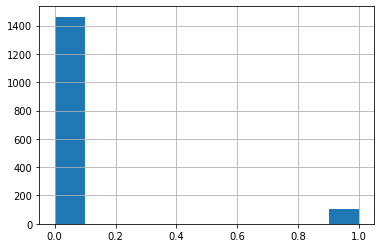

In [4]:
labels_df['Label'] = labels_df['Label'].apply(lambda x: 0 if x == -1 else 1)
labels_df['Label'].hist()

In [5]:
label_sum = labels_df['Label'].groupby(labels_df['Date'].dt.date).sum().reset_index()
label_count = labels_df['Label'].groupby(labels_df['Date'].dt.date).count().reset_index()
label_day = pd.merge(label_sum, label_count, on='Date')
label_day.columns = ['Date', 'Sum', 'Count']
label_day['Date'] = pd.to_datetime(label_day['Date'])
label_day.head()

,Date,Sum,Count
0,2008-07-19,3,12
1,2008-07-20,0,1
2,2008-07-21,1,2
3,2008-07-22,0,6
4,2008-07-23,0,2


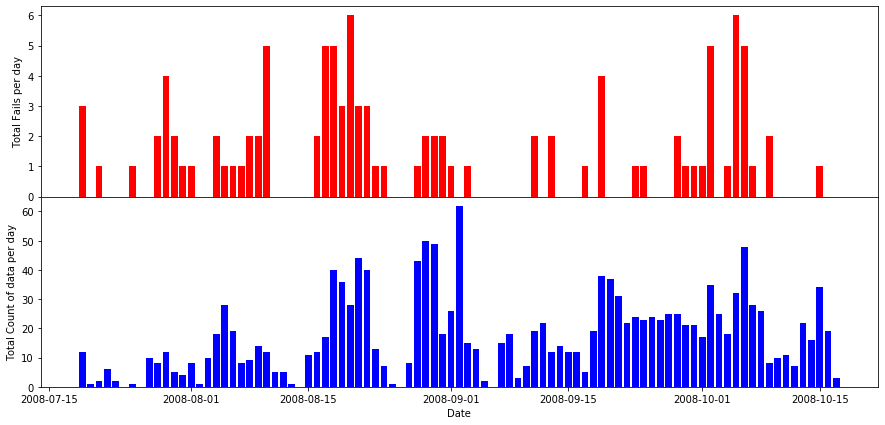

In [6]:
# Create a figure with shared X axis
fig, axs = plt.subplots(2, 1, sharex=True, figsize = (15,7))

# Remove horizontal space between axes
fig.subplots_adjust(hspace=0)

# Set the width of the bars to be 1 day
#width = np.timedelta64(1, 'D')

# Plot the Sum of fails per day and count of entries per day
axs[0].bar(label_day['Date'], label_day['Sum'], color = 'red')
axs[1].bar(label_day['Date'], label_day['Count'], color = 'blue')
axs[0].set_ylabel('Total Fails per day')
axs[1].set_ylabel('Total Count of data per day')
axs[1].set_xlabel('Date');

# Data

In [7]:
data_df = pd.read_csv('data/secom.data', sep=' ', header = None)
print('data_df shape = {}'.format(data_df.shape))
data_df.columns = ['x_{}'.format(i) for i in range (0,590)]
data_df.head()

data_df shape = (1567, 590)


,x_0,x_1,x_2,x_3,x_4,x_5,x_6,x_7,x_8,x_9,...,x_580,x_581,x_582,x_583,x_584,x_585,x_586,x_587,x_588,x_589
0,3030.93,2564.00,2187.7333,1411.1265,1.3602,100.0,97.6133,0.1242,1.5005,0.0162,...,NaN,NaN,0.5005,0.0118,0.0035,2.3630,NaN,NaN,NaN,NaN
1,3095.78,2465.14,2230.4222,1463.6606,0.8294,100.0,102.3433,0.1247,1.4966,-0.0005,...,0.0060,208.2045,0.5019,0.0223,0.0055,4.4447,0.0096,0.0201,0.0060,208.2045
2,2932.61,2559.94,2186.4111,1698.0172,1.5102,100.0,95.4878,0.1241,1.4436,0.0041,...,0.0148,82.8602,0.4958,0.0157,0.0039,3.1745,0.0584,0.0484,0.0148,82.8602
3,2988.72,2479.90,2199.0333,909.7926,1.3204,100.0,104.2367,0.1217,1.4882,-0.0124,...,0.0044,73.8432,0.4990,0.0103,0.0025,2.0544,0.0202,0.0149,0.0044,73.8432
4,3032.24,2502.87,2233.3667,1326.5200,1.5334,100.0,100.3967,0.1235,1.5031,-0.0031,...,NaN,NaN,0.4800,0.4766,0.1045,99.3032,0.0202,0.0149,0.0044,73.8432


# Merging Data and Labels

In [8]:
merged_df = data_df.merge(labels_df, left_index=True, right_index=True)
print(merged_df.shape)
merged_df.head()

(1567, 592)


,x_0,x_1,x_2,x_3,x_4,x_5,x_6,x_7,x_8,x_9,...,x_582,x_583,x_584,x_585,x_586,x_587,x_588,x_589,Label,Date
0,3030.93,2564.00,2187.7333,1411.1265,1.3602,100.0,97.6133,0.1242,1.5005,0.0162,...,0.5005,0.0118,0.0035,2.3630,NaN,NaN,NaN,NaN,0,2008-07-19 11:55:00
1,3095.78,2465.14,2230.4222,1463.6606,0.8294,100.0,102.3433,0.1247,1.4966,-0.0005,...,0.5019,0.0223,0.0055,4.4447,0.0096,0.0201,0.0060,208.2045,0,2008-07-19 12:32:00
2,2932.61,2559.94,2186.4111,1698.0172,1.5102,100.0,95.4878,0.1241,1.4436,0.0041,...,0.4958,0.0157,0.0039,3.1745,0.0584,0.0484,0.0148,82.8602,1,2008-07-19 13:17:00
3,2988.72,2479.90,2199.0333,909.7926,1.3204,100.0,104.2367,0.1217,1.4882,-0.0124,...,0.4990,0.0103,0.0025,2.0544,0.0202,0.0149,0.0044,73.8432,0,2008-07-19 14:43:00
4,3032.24,2502.87,2233.3667,1326.5200,1.5334,100.0,100.3967,0.1235,1.5031,-0.0031,...,0.4800,0.4766,0.1045,99.3032,0.0202,0.0149,0.0044,73.8432,0,2008-07-19 15:22:00


# Helper Class

In [25]:
class labels_prediction:
    def __init__(self):
        self.params_init()
        self.models_init()
    
    def params_init(self):
        self.sgd_param = {
            'rus__sampling_strategy' : ['auto', 0.5, 0.8],
            'rus__replacement' : ['False', 'True'],
            'sgd__loss' : ['hinge', 'log', 'modified_huber', 'squared_hinge', 'perceptron'],
            'sgd__alpha' : [0.00001, 0.0001, 0.001],
            'sgd__learning_rate' : ['optimal', 'invscaling', 'adaptive'],
            'sgd__eta0' : [0.001],
            'sgd__class_weight' : [None]
        }

        self.lr_param = {
            'rus__sampling_strategy' : ['auto', 0.5, 0.8],
            'rus__replacement' : ['False', 'True'],
            'lr__C' : [1,10,100,500,1000],
            'lr__solver' : ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
            'lr__class_weight' : [None]
        }

        self.svc_param = {
            'rus__sampling_strategy' : ['auto', 0.5, 0.8],
            'rus__replacement' : ['False', 'True'],
            'svc__C' : [1,10,100,500,1000],
            'svc__class_weight' : [None]
        }

        self.ab_param = {
            'rus__sampling_strategy' : ['auto', 0.5, 0.8],
            'rus__replacement' : ['False', 'True'],
            'ab__n_estimators' : [50, 100, 200, 500],
            'ab__learning_rate' : [0.001, 0.01, 0.1, 0.5, 1]
        }

        self.bag_param = {
            'rus__sampling_strategy' : ['auto', 0.5, 0.8],
            'rus__replacement' : ['False', 'True'],
            'bag__n_estimators' : [50, 100, 200, 500],
            'bag__max_samples' : [1, 0.8],
            'bag__max_features' : [1, 0.8, 0.6],
            'bag__bootstrap' : [True, False],
            'bag__bootstrap_features' : [True, False],
            'bag__oob_score' : [False]
        }

        self.rf_param = {
            'rus__sampling_strategy' : ['auto', 0.5, 0.8],
            'rus__replacement' : ['False', 'True'],
            'rf__n_estimators' : [100, 200, 500],
            'rf__criterion' : ['gini', 'entropy'],
            'rf__max_depth' : [2, 5, 8],
            'rf__min_samples_split' : [5, 10, 20],
            'rf__min_samples_leaf' : [2, 4, 6],
            'rf__max_features' : ['auto', 'sqrt', 'log2', None],
            'rf__bootstrap' : [True, False],
        }

        self.gbc_param = {
            'rus__sampling_strategy' : ['auto', 0.5, 0.8],
            'rus__replacement' : ['False', 'True'],
            'gbc__max_depth' : [2, 5, 8],
            'gbc__max_features' : ['auto', 'sqrt', 'log2', None],
            'gbc__min_samples_leaf' : [2, 4, 6],
            'gbc__min_samples_split': [5, 10, 20],  
            'gbc__n_estimators' : [100, 200, 500],
            'gbc__learning_rate' : [0.01, 0.1, 0.2],
            'gbc__subsample' : [1, 0.8, 0.6],
        }
           
    def models_init(self):
        # Impute missing values
        self.imputer = SimpleImputer(strategy='mean')

        # Scaling
        self.scaler = StandardScaler()

        # Models
        self.sgd_model = SGDClassifier()
        self.lr_model = LogisticRegression()
        self.svc_model = LinearSVC(loss='hinge')
        self.ab_model = AdaBoostClassifier()
        self.bag_model = BaggingClassifier()
        self.rf_model = RandomForestClassifier()
        self.gbc_model = GradientBoostingClassifier()

        # Sampling
        self.rus = RandomUnderSampler()
        self.smt = SMOTE()

        # Cross Validation

        # Pipeline

        # Metrics

        self.models = {
            'sgd': {'est' : self.sgd_model, 'params': self.sgd_param}, 
            'lr': {'est' : self.lr_model, 'params': self.lr_param}, 
            'svc': {'est' : self.svc_model, 'params': self.svc_param}, 
            'ab': {'est' : self.ab_model, 'params': self.ab_param},
            'bag': {'est' : self.bag_model, 'params': self.bag_param}, 
            'rf': {'est' : self.rf_model, 'params': self.rf_param}, 
            'gbc': {'est' : self.gbc_model, 'params': self.gbc_param}
        }
        
    def train_models(self, X_train, y_train):
        # Training with cross validation and hyperparameter tuning
        start = datetime.now()

        self.best_estimators = {}
        self.best_f1_scores = {}
        self.scores_all = []
        for model, estimator in self.models.items():
            model_pipeline = Pipeline([
                ('imputer', self.imputer),
                ('scaling', self.scaler),
                ('rus', self.rus),
                (model, estimator['est'])
                ])

            search = RandomizedSearchCV(model_pipeline, param_distributions=estimator['params'], scoring='f1', n_iter=100, cv=10, verbose=False, n_jobs=-1, iid=False)
            #search = GridSearchCV(model_pipeline, param_grid=param_dist, scoring='f1', cv=10, verbose=True, n_jobs=-1)
            search.fit(X_train, y_train)
            self.best_estimators[model] = search.best_estimator_
            self.best_f1_scores[model] = search.best_score_
            print('{} best F1 score: {:.4f}'.format(model, search.best_score_))
       
        # Training a Voting classifier with all above estimators
        self.vot_model = VotingClassifier(estimators=list(self.best_estimators.items()), voting='hard')
        scores = cross_val_score(self.vot_model, X_train, y_train, scoring='f1', cv=10)
        self.vot_model.fit(X_train,y_train)
        self.best_estimators['voting'] = self.vot_model
        print('Voting Classifier F1 score mean: {:.4f}, stddev: {:.4f}'.format(scores.mean(), scores.std()))
        
        end = datetime.now()
        print('Train time: {}'.format(end-start))
        
    def test_models(self, X_train, y_train, X_test, y_test):
        # Plot the performance metrics on Train and Test datasets
        i=0
        fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14,5))
        for dataset in [[X_train, y_train], [X_test, y_test]]:
            model_metrics = {}
            auc_all, precision_all, recall_all, f1_all, model_names = [], [], [], [], []
            for model, estimator in self.best_estimators.items():
                y_pred = self.best_estimators[model].predict(dataset[0])
                fpr, tpr, thresholds = roc_curve(dataset[1], y_pred)
                precision = precision_score(dataset[1], y_pred)
                recall = recall_score(dataset[1], y_pred)
                fmeasure = f1_score(dataset[1], y_pred)
                model_metrics[model] = {}
                model_metrics[model]['auc'] = auc(fpr, tpr)
                model_metrics[model]['precision'] = precision
                model_metrics[model]['recall'] = recall
                model_metrics[model]['f1_score'] = fmeasure

            df = pd.DataFrame(model_metrics)
            df.plot.bar(ax=axes[i], legend=None)
            axes[i].tick_params(direction='out', labelsize=14)
            if i:
                axes[i].legend(fontsize=14, bbox_to_anchor=(1, 1))
            axes[i].set_ylim(0,1)
            i+=1
        axes[0].set_title("Train Dataset", fontsize=14)
        axes[1].set_title("Test Dataset", fontsize=14)

# Method1: Split Train and Test randomly

In [13]:
from sklearn.model_selection import train_test_split
X = merged_df.iloc[:,:-2]
y = merged_df['Label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [14]:
lp = labels_prediction()

In [15]:
lp.train_models(X_train, y_train)

sgd best F1 score: 0.1970
lr best F1 score: 0.1927
svc best F1 score: 0.1831
ab best F1 score: 0.2537
bag best F1 score: 0.2703
rf best F1 score: 0.2517
gbc best F1 score: 0.2462
Train time: 0:21:11.666274
Voting Classifier F1 score mean: 0.2134, stddev: 0.0992


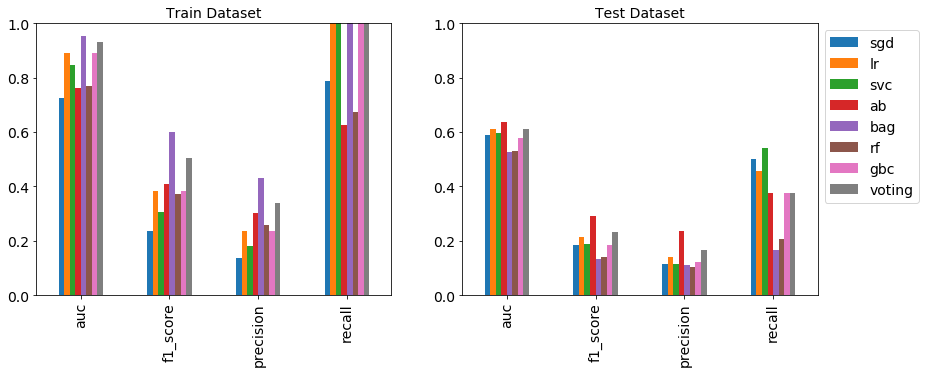

In [16]:
lp.test_models(X_train, y_train, X_test, y_test)

The best models have roughly ~0.65 AUC on testing set. AdaBoost looks best overall with the highest AUC, precision and f1_score

# Method2: Split Train and Test by Date

In [17]:
# Split Train and Test by date
split_date = '2008-10-01'
train_df = merged_df[merged_df['Date'] < split_date]
test_df = merged_df[merged_df['Date'] >= split_date]
print('train df shape: {}, test df shape: {}'.format(train_df.shape, test_df.shape))

train df shape: (1208, 592), test df shape: (359, 592)


In [21]:
X_train_2 = train_df.iloc[:,:-2]
y_train_2 = train_df['Label']
X_test_2 = test_df.iloc[:,:-2]
y_test_2 = test_df['Label']

In [22]:
lp2 = labels_prediction()

In [23]:
lp2.train_models(X_train_2, y_train_2)

sgd best F1 score: 0.1630
lr best F1 score: 0.1548
svc best F1 score: 0.1559
ab best F1 score: 0.3465
bag best F1 score: 0.3378
rf best F1 score: 0.3381
gbc best F1 score: 0.2601
Train time: 0:21:43.905278
Voting Classifier F1 score mean: 0.2259, stddev: 0.1302


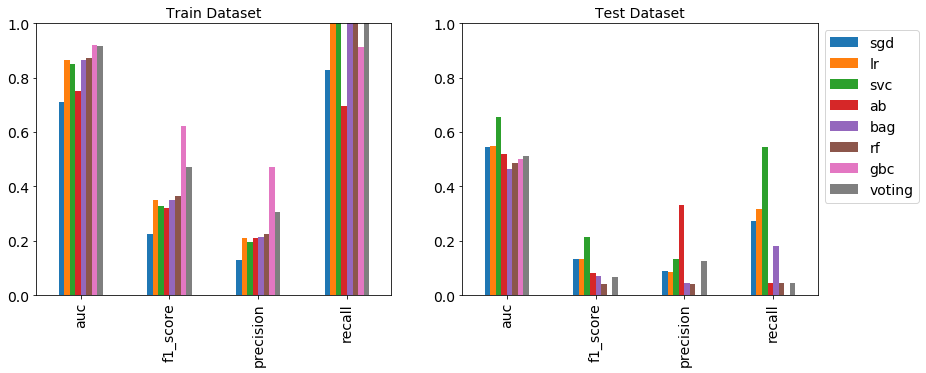

In [24]:
lp2.test_models(X_train_2, y_train_2, X_test_2, y_test_2)

Here SVC seems to be the best model with ~0.68 AUC and 0.6 recall

# Conclusion:
1. No good models could be found. Best model has ~0.68AUC
2. Depending on the test set, best model is either Ada Boost or SVC

# Study prediction errors

In [91]:
y_pred_all, model_names = [], []
for model, estimator in lp.best_estimators.items():
    y_pred = estimator.predict(X_train)
    y_pred_all.append(y_pred)
    model_names.append(model)

In [92]:
df = pd.DataFrame(y_pred_all).T
df.columns = model_names
df.head()

,sgd,lr,svc,ab,bag,rf,gbc,voting
0,1,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0
2,1,1,1,1,1,1,1,1
3,1,0,1,0,1,1,0,1
4,1,1,1,0,0,1,0,0


In [93]:
df_merged = df.merge(y_train.reset_index(drop=True), left_index=True, right_index=True)
df_merged.head()

,sgd,lr,svc,ab,bag,rf,gbc,voting,Label
0,1,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0
2,1,1,1,1,1,1,1,1,1
3,1,0,1,0,1,1,0,1,0
4,1,1,1,0,0,1,0,0,0


In [94]:
corr=df_merged.corr()
corr.style.background_gradient(cmap='coolwarm')

,sgd,lr,svc,ab,bag,rf,gbc,voting,Label
sgd,1,0.413927,0.235557,0.312829,0.370865,0.397435,0.371522,0.423709,0.194274
lr,0.413927,1,0.338537,0.356335,0.425926,0.381715,0.37723,0.454577,0.352511
svc,0.235557,0.338537,1,0.194712,0.226651,0.165768,0.267624,0.303399,0.289759
ab,0.312829,0.356335,0.194712,1,0.576371,0.594317,0.557204,0.597792,0.387241
bag,0.370865,0.425926,0.226651,0.576371,1,0.646166,0.589397,0.684657,0.484476
rf,0.397435,0.381715,0.165768,0.594317,0.646166,1,0.570154,0.616475,0.310957
gbc,0.371522,0.37723,0.267624,0.557204,0.589397,0.570154,1,0.652274,0.344564
voting,0.423709,0.454577,0.303399,0.597792,0.684657,0.616475,0.652274,1,0.442034
Label,0.194274,0.352511,0.289759,0.387241,0.484476,0.310957,0.344564,0.442034,1


In terms of predictions, some classifiers seems correlated to each other. Hence, let's try to build a voting classifier with only classifiers that dont correlate well

In [98]:
new_vot_model = VotingClassifier(estimators=[('sgd', lp.best_estimators['sgd']),
                                             ('lr', lp.best_estimators['lr']),
                                             ('svc', lp.best_estimators['svc']),
                                             ('bag', lp.best_estimators['bag']),
                                             ('gbc', lp.best_estimators['gbc'])
                                            ], voting='hard')
scores = cross_val_score(new_vot_model, X_train, y_train, scoring='f1', cv=10)
new_vot_model.fit(X_train,y_train)
print('Train New Voting Classifier F1 score mean: {:.4f}, stddev: {:.4f}'.format(scores.mean(), scores.std()))

Train New Voting Classifier F1 score mean: 0.1428, stddev: 0.0648


No improvement in cross val scores

In [ ]:
# Chi square
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.preprocessing import MinMaxScaler

def feature_prescreen(df_data, X, y):      
    data_X = df_data[X]
    data_X = data_X.fillna(data_X.median()).fillna(0).as_matrix().astype(float)
    
    scaler = MinMaxScaler()
    data_X = scaler.fit_transform(data_X)    
    data_Y = df_data[y].apply(lambda x: 0 if x==0 else 1).as_matrix() 
    
    # Get top features
    feature_selector = SelectKBest(chi2, k='all') 
    feature_selector.fit(data_X, data_Y)
    feature_idx = np.arange(data_X.shape[1])[feature_selector.get_support()].tolist()
    features = np.array(X)[feature_idx].tolist()
    scores = feature_selector.scores_[feature_idx].tolist()    
    pvalues = feature_selector.pvalues_[feature_idx].tolist()    
    
    feature_prescreen_ranking = pd.DataFrame({'feature': features, 'score': scores, 'pvalue': pvalues})    
    feature_prescreen_ranking = feature_prescreen_ranking.sort_values(['score'], ascending=False).reset_index()   
    
    return feature_prescreen_ranking

df_modelling_data = X_train_imp_scaled.merge(y_train, left_index=True, right_index=True)
X = df_modelling_data.columns[:-1]
y = 'Label'

PRESCREEN_CHI_SQUARED_PVALUE = 0.5 #Tuning Parameter

feature_prescreen_ranking = feature_prescreen(df_modelling_data, X, y) 
prescreen_features = feature_prescreen_ranking[feature_prescreen_ranking['pvalue'] < PRESCREEN_CHI_SQUARED_PVALUE]['feature'].tolist()

# Split features (X) and response (y)
X_train = X_train_imp_scaled[prescreen_features].reset_index(drop=True)
X_test = X_test_imp_scaled[prescreen_features].reset_index(drop=True)